In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Load the full data
data = pd.read_parquet(
    "/content/drive/MyDrive/Colab Notebooks/5km_resolution_with_missing_data_handled_2022_to_2025.parquet",
    engine='pyarrow'
)

print("Shape:", data.shape)
print("Columns:", data.columns.tolist())
print(data.head())


Shape: (14146902, 13)
Columns: ['lat_5km', 'lon_5km', 'KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM', 'time', 'flags', 'date']
   lat_5km  lon_5km     KD490        ZSD  RRS490  RRS443       CHL  MICRO  \
0    49.15   -10.75  0.035727  26.936846    -2.0    -2.0  0.124980   -2.0   
1    49.15   -10.70  0.035727  26.936848    -2.0    -2.0  0.124980   -2.0   
2    49.15   -10.65  0.035787  26.878199    -2.0    -2.0  0.125559   -2.0   
3    49.15   -10.60  0.035876  26.790228    -2.0    -2.0  0.126427   -2.0   
4    49.15   -10.55  0.035876  26.790228    -2.0    -2.0  0.126427   -2.0   

   BBP  CDM       time  flags        date  
0 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
1 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
2 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
3 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
4 -2.0 -2.0 2025-01-01    0.0  2025-01-01  


## Data Preprocessing: Removing Land Data and missing values

In [3]:
# Data Preprocessing: Remove Land Data

# Define parameter columns that contain -1.0 for land data
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

# Filter out rows where "flags" column is 1.0 (land data)
data = data[data["flags"] != 1.0].copy()

# Filter out rows where any parameter column contains -1.0 (land data)
# Use .any(axis=1) to check if -1.0 exists in any of the specified columns for a given row
land_data_in_params = (data[parameter_columns] == -1.0).any(axis=1)
data = data[~land_data_in_params].copy()

print(f"Shape after removing land data: {data.shape}")



Shape after removing land data: (10987584, 13)


In [4]:
# Missing Data Handling (-2.0)
import numpy as np

# Replace -2.0 values in parameter columns with NaN
for col in parameter_columns:
    data[col] = data[col].replace(-2.0, np.nan)

print("Missing data (-2.0) replaced with NaN.")
print("NaN counts per parameter column after replacement:")
print(data[parameter_columns].isnull().sum())

Missing data (-2.0) replaced with NaN.
NaN counts per parameter column after replacement:
KD490           0
ZSD             0
RRS490    1443936
RRS443    1443936
CHL             0
MICRO     1871136
BBP       1666080
CDM       1666080
dtype: int64


In [5]:
# Remove Rows with Any NaN Values
# Get the initial shape before dropping NaNs
initial_rows = data.shape[0]

data.dropna(inplace=True)

# Get the shape after dropping NaNs
final_rows = data.shape[0]

print(f"\nRemoved {initial_rows - final_rows} rows containing NaN values.")
print(f"New Data Shape after dropping NaNs: {data.shape}")


Removed 1871136 rows containing NaN values.
New Data Shape after dropping NaNs: (9116448, 13)


In [6]:
# Convert to datetime if needed
data['date'] = pd.to_datetime(data['date'])

# Unique sorted dates
unique_dates = pd.Series(data['date'].unique()).sort_values()
print(f"\nNumber of unique dates: {len(unique_dates)}")
print(f"Date range: {unique_dates.min().date()} to {unique_dates.max().date()}")

# Full expected date range (daily)
expected_dates = pd.date_range(start=unique_dates.min(), end=unique_dates.max(), freq='D')

# Find missing dates
missing_dates = set(expected_dates) - set(unique_dates)
if missing_dates:
    print(f"\nMissing dates: {len(missing_dates)}")
    print("Example missing dates:", sorted(missing_dates)[:10])
else:
    print("\n All dates are continuous.")



Number of unique dates: 1067
Date range: 2022-01-27 to 2025-07-21

Missing dates: 205
Example missing dates: [Timestamp('2022-11-21 00:00:00'), Timestamp('2022-11-22 00:00:00'), Timestamp('2022-11-23 00:00:00'), Timestamp('2022-11-24 00:00:00'), Timestamp('2022-11-25 00:00:00'), Timestamp('2022-11-26 00:00:00'), Timestamp('2022-11-27 00:00:00'), Timestamp('2022-11-28 00:00:00'), Timestamp('2022-11-29 00:00:00'), Timestamp('2022-11-30 00:00:00')]


In [7]:
import numpy as np

# Ensure date is datetime
data['date'] = pd.to_datetime(data['date'])

# Define specific date ranges for train, validation, and test sets
train_start = pd.to_datetime('2022-01-27')
train_end = pd.to_datetime('2023-11-17')
val_start = pd.to_datetime('2024-01-26')
val_end = pd.to_datetime('2024-07-31')
test_start = pd.to_datetime('2024-08-01')
test_end = pd.to_datetime('2025-07-21')

# Get unique dates in the dataset
unique_dates = sorted(data['date'].unique())

# Filter dates based on the specified ranges
train_dates = [date for date in unique_dates if train_start <= date <= train_end]
val_dates = [date for date in unique_dates if val_start <= date <= val_end]
test_dates = [date for date in unique_dates if test_start <= date <= test_end]

print(f"Train: {len(train_dates)} days")
print(f"Val: {len(val_dates)} days")
print(f"Test: {len(test_dates)} days")
print(f"Total days: {len(train_dates) + len(val_dates) + len(test_dates)}")

if train_dates:
    print(f"Train: {train_dates[0].date()} → {train_dates[-1].date()}")
if val_dates:
    print(f"Val:   {val_dates[0].date()} → {val_dates[-1].date()}")
if test_dates:
    print(f"Test:  {test_dates[0].date()} → {test_dates[-1].date()}")


Train: 593 days
Val: 188 days
Test: 286 days
Total days: 1067
Train: 2022-01-27 → 2023-11-17
Val:   2024-01-26 → 2024-07-31
Test:  2024-08-01 → 2025-07-21


In [ ]:
# Create and Save Tensors for Train, Validation, and Test Sets
import numpy as np

# Define feature columns for tensor creation (excluding lat/lon for the 4D tensor)
feature_columns_4d = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

# Get unique latitudes and longitudes to determine spatial dimensions
unique_lats = sorted(data["lat_5km"].unique())
unique_lons = sorted(data["lon_5km"].unique())

print(f"Number of unique latitudes: {len(unique_lats)}")
print(f"Number of unique longitudes: {len(unique_lons)}")

# Function to reshape data into 4D tensor
def reshape_to_4d(df, dates, lats, lons, features):
    num_dates = len(dates)
    num_features = len(features)
    num_lats = len(lats)
    num_lons = len(lons)

    # Initialize an empty tensor with NaNs
    tensor = np.full((num_dates, num_features, num_lats, num_lons), np.nan, dtype=np.float32)

    for i, date in enumerate(dates):
        daily_data = df[df["date"] == date]
        for _, row in daily_data.iterrows():
            lat_idx = lats.index(row["lat_5km"])
            lon_idx = lons.index(row["lon_5km"])
            for j, feature in enumerate(features):
                tensor[i, j, lat_idx, lon_idx] = row[feature]
    return tensor

# Create 4D tensors for each split
train_tensor_4d = reshape_to_4d(data, train_dates, unique_lats, unique_lons, feature_columns_4d)
val_tensor_4d = reshape_to_4d(data, val_dates, unique_lats, unique_lons, feature_columns_4d)
test_tensor_4d = reshape_to_4d(data, test_dates, unique_lats, unique_lons, feature_columns_4d)

# Save 4D tensors as .npy files
np.save("train_tensor_4d_new_split.npy", train_tensor_4d)
np.save("val_tensor_4d_new_split.npy", val_tensor_4d)
np.save("test_tensor_4d_new_split.npy", test_tensor_4d)

print(f"Train 4D tensor shape: {train_tensor_4d.shape}")
print(f"Validation 4D tensor shape: {val_tensor_4d.shape}")
print(f"Test 4D tensor shape: {test_tensor_4d.shape}")
print("\n4D Tensors saved successfully!")
print("Files created:")
print("- train_tensor_4d_new_split.npy")
print("- val_tensor_4d_new_split.npy")
print("- test_tensor_4d_new_split.npy")

# Display feature column mapping for 4D tensor
print("\nFeature column mapping (8 features for 4D tensor):")
for i, col in enumerate(feature_columns_4d):
    print(f"Dimension {i}: {col}")

# Display tensor dimensions explanation
print("\nTensor dimensions explanation:")
print("Dimension 0: Time (number of dates)")
print("Dimension 1: Features (8 oceanographic parameters)")
print("Dimension 2: Latitude (spatial dimension)")
print("Dimension 3: Longitude (spatial dimension)")

Number of unique latitudes: 63
Number of unique longitudes: 173
Train 4D tensor shape: (593, 8, 63, 173)
Validation 4D tensor shape: (188, 8, 63, 173)
Test 4D tensor shape: (286, 8, 63, 173)

4D Tensors saved successfully!
Files created:
- train_tensor_4d_new_split.npy
- val_tensor_4d_new_split.npy
- test_tensor_4d_new_split.npy

Feature column mapping (8 features for 4D tensor):
Dimension 0: KD490
Dimension 1: ZSD
Dimension 2: RRS490
Dimension 3: RRS443
Dimension 4: CHL
Dimension 5: MICRO
Dimension 6: BBP
Dimension 7: CDM

Tensor dimensions explanation:
Dimension 0: Time (number of dates)
Dimension 1: Features (8 oceanographic parameters)
Dimension 2: Latitude (spatial dimension)
Dimension 3: Longitude (spatial dimension)


In [8]:
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 13.8 MB/s eta 0:00:00


# EXPONENTIAL SMOOTHING

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [15]:
ALPHA = 0.3
min_points = 15  # for picking a representative grid for the panel plot

def symmetric_mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return 100.0 * np.mean(np.where(denom == 0, 0.0, np.abs(y_pred - y_true) / (denom + eps)))

variables = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]
results_es = {}

#  compute predictions for per-grid ES and global metrics
all_pred_by_var = {}  # store pred_df per variable for plotting

for var in variables:
    df_var = data[["date", "lat_5km", "lon_5km", var]].dropna().copy()
    df_var.sort_values(by=["lat_5km", "lon_5km", "date"], inplace=True)

    predictions = []
    for (lat, lon), group in df_var.groupby(["lat_5km", "lon_5km"]):
        g = group.set_index("date").sort_index()
        series = g[var]
        if len(series) < 10:
            continue

        train_series = series[series.index.isin(train_dates)]
        val_series   = series[series.index.isin(val_dates)]
        if len(train_series) < 5 or len(val_series) == 0:
            continue

        # Fit SES on train; no leakage
        model = SimpleExpSmoothing(train_series).fit(smoothing_level=ALPHA, optimized=False)
        last_fitted = model.fittedvalues[-1]

        # Recursive one-step-ahead for val
        for d in val_series.index:
            hist = series.loc[:d]
            prev_value = hist.iloc[-2] if len(hist) > 1 else last_fitted
            last_fitted = ALPHA * prev_value + (1.0 - ALPHA) * last_fitted
            predictions.append((d, lat, lon, val_series.loc[d], last_fitted))

    if not predictions:
        print(f"[{var}] Not enough data for evaluation.")
        continue

    pred_df = pd.DataFrame(predictions, columns=["date", "lat_5km", "lon_5km", "actual", "predicted"])
    all_pred_by_var[var] = pred_df

    # Global (micro) metrics across all (date, lat, lon) rows
    err = pred_df["predicted"].to_numpy() - pred_df["actual"].to_numpy()
    mae  = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    smape = float(symmetric_mape(pred_df["actual"], pred_df["predicted"]))

    results_es[var] = {"SMAPE (%)": smape, "RMSE": rmse, "MAE": mae}

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipython-input-1187597650.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_fitted = model.fittedvalues[-1]
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipython-input-1187597650.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

In [16]:
# Final summary for Exponential Smoothing
print("\nSummary of Evaluation Metrics (Exponential Smoothing):")
exp_summary_df = pd.DataFrame(results_es).T.round(4)
print(exp_summary_df)


Summary of Evaluation Metrics (Exponential Smoothing):
        SMAPE (%)    RMSE     MAE
KD490     10.8123  0.0258  0.0117
ZSD       12.3311  1.7683  1.1878
RRS490    17.8948  0.0016  0.0010
RRS443    21.9537  0.0016  0.0010
CHL       19.9319  0.8381  0.2785
MICRO     60.3603  3.9746  1.2130
BBP       25.4569  0.0047  0.0021
CDM       23.8046  0.0768  0.0184


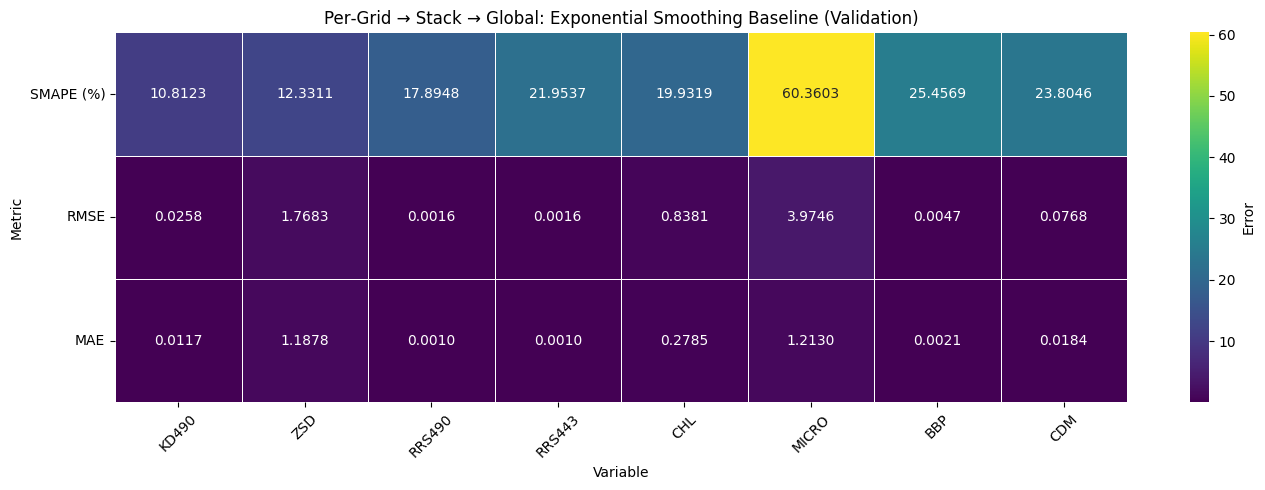

In [17]:
metrics_df_es = pd.DataFrame(results_es).T
wanted = ["SMAPE (%)", "RMSE", "MAE"]
for col in wanted:
    if col not in metrics_df_es.columns:
        metrics_df_es[col] = np.nan

heatmap_data_es = metrics_df_es[wanted].T

plt.figure(figsize=(14, 5))
sns.heatmap(
    heatmap_data_es,
    annot=True, fmt=".4f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Error"}
)
plt.title("Per‑Grid → Stack → Global: Exponential Smoothing Baseline (Validation)")
plt.xlabel("Variable"); plt.ylabel("Metric")
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

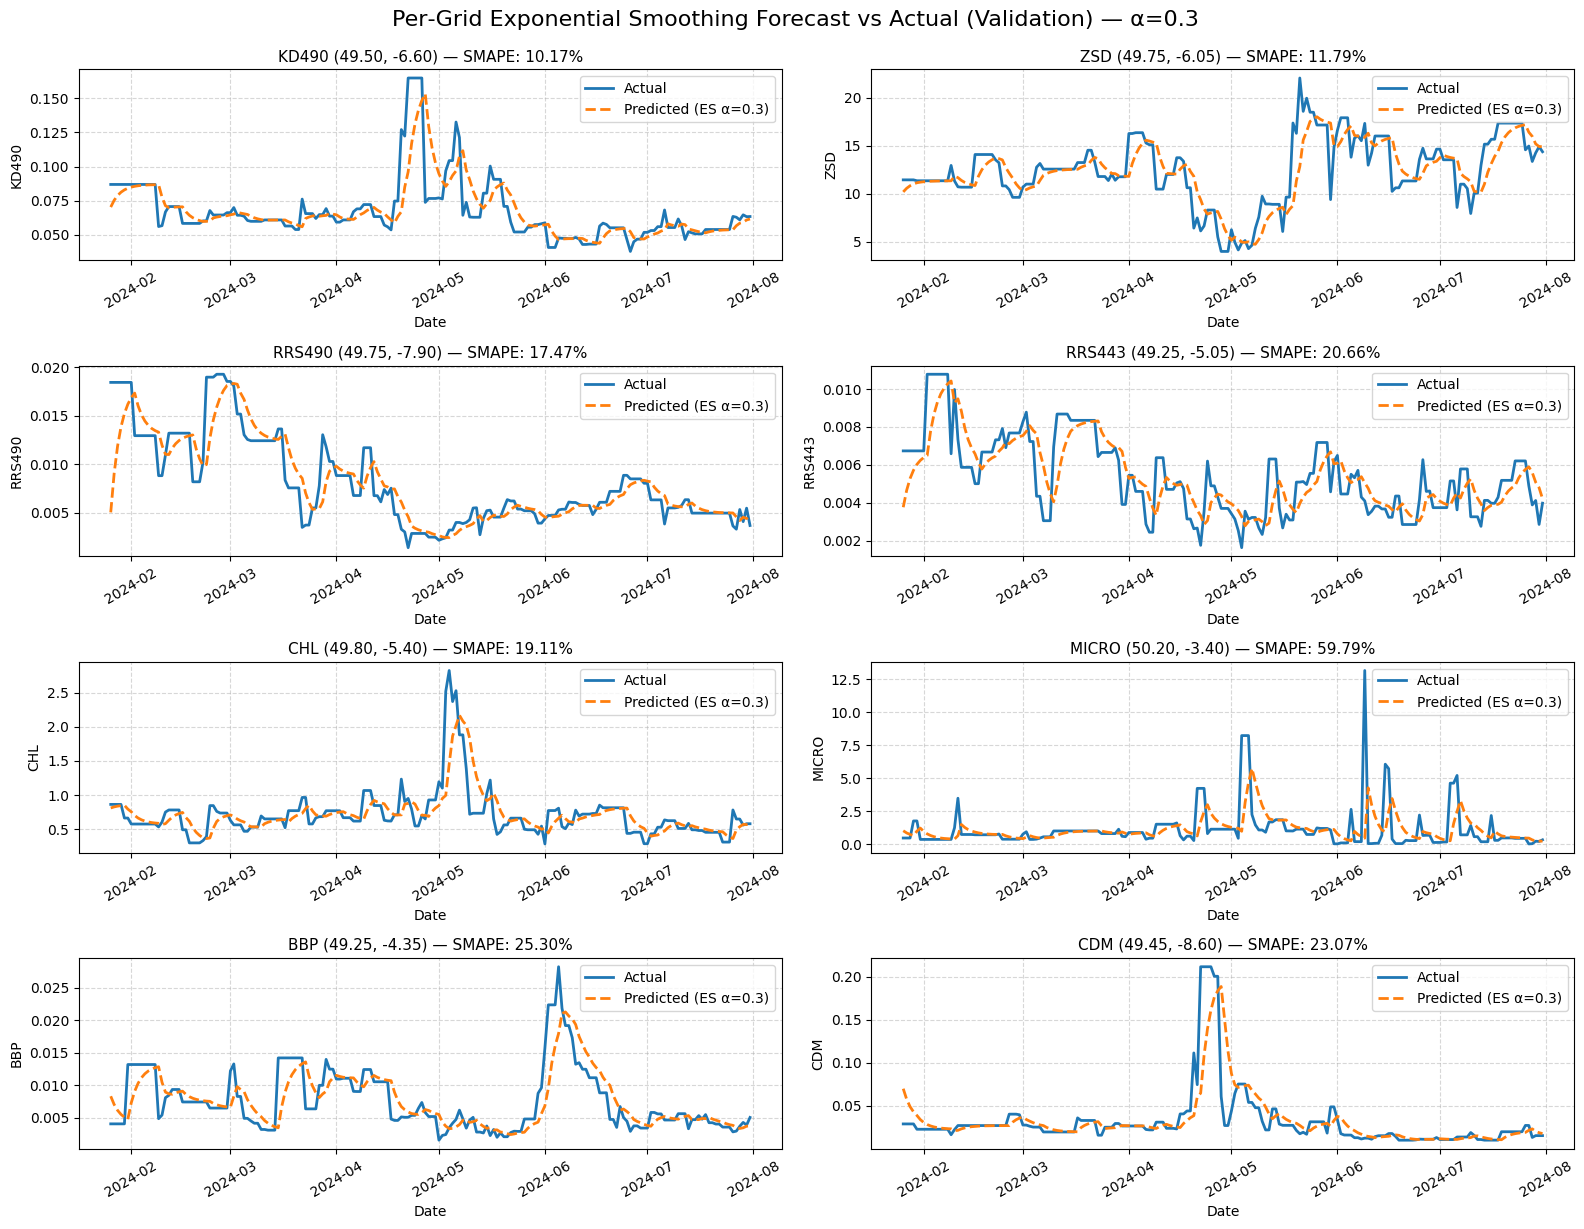

In [19]:
min_points = 15
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    if var not in all_pred_by_var:
        ax.set_title(f"{var} — No validation predictions"); ax.axis("off")
        continue

    pred_df = all_pred_by_var[var].copy()
    # compute SMAPE per grid on validation rows
    smape_rows = []
    for (lat, lon), g in pred_df.groupby(["lat_5km", "lon_5km"]):
        if len(g) < min_points:
            continue
        s = symmetric_mape(g["actual"].to_numpy(), g["predicted"].to_numpy())
        smape_rows.append((lat, lon, s))

    if not smape_rows:
        ax.set_title(f"{var} — No grid with ≥{min_points} pts"); ax.axis("off")
        continue

    smapes = np.array([r[2] for r in smape_rows])
    med = np.median(smapes)
    lat_sel, lon_sel, smape_sel = min(smape_rows, key=lambda r: abs(r[2] - med))

    gsel = pred_df[(pred_df["lat_5km"] == lat_sel) & (pred_df["lon_5km"] == lon_sel)].copy()
    gsel.sort_values("date", inplace=True)

    ax.plot(gsel["date"], gsel["actual"], linewidth=2.0, label="Actual")
    ax.plot(gsel["date"], gsel["predicted"], linestyle="--", linewidth=2.0, label=f"Predicted (ES α={ALPHA})")
    ax.set_title(f"{var} ({lat_sel:.2f}, {lon_sel:.2f}) — SMAPE: {smape_sel:.2f}%", fontsize=11)
    ax.set_xlabel("Date"); ax.set_ylabel(var)
    ax.tick_params(axis="x", rotation=30)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.suptitle(f"Per‑Grid Exponential Smoothing Forecast vs Actual (Validation) — α={ALPHA}", fontsize=16, y=1.02)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipython-input-2757574007.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_fitted = model.fittedvalues[-1]
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipython-input-2757574007.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

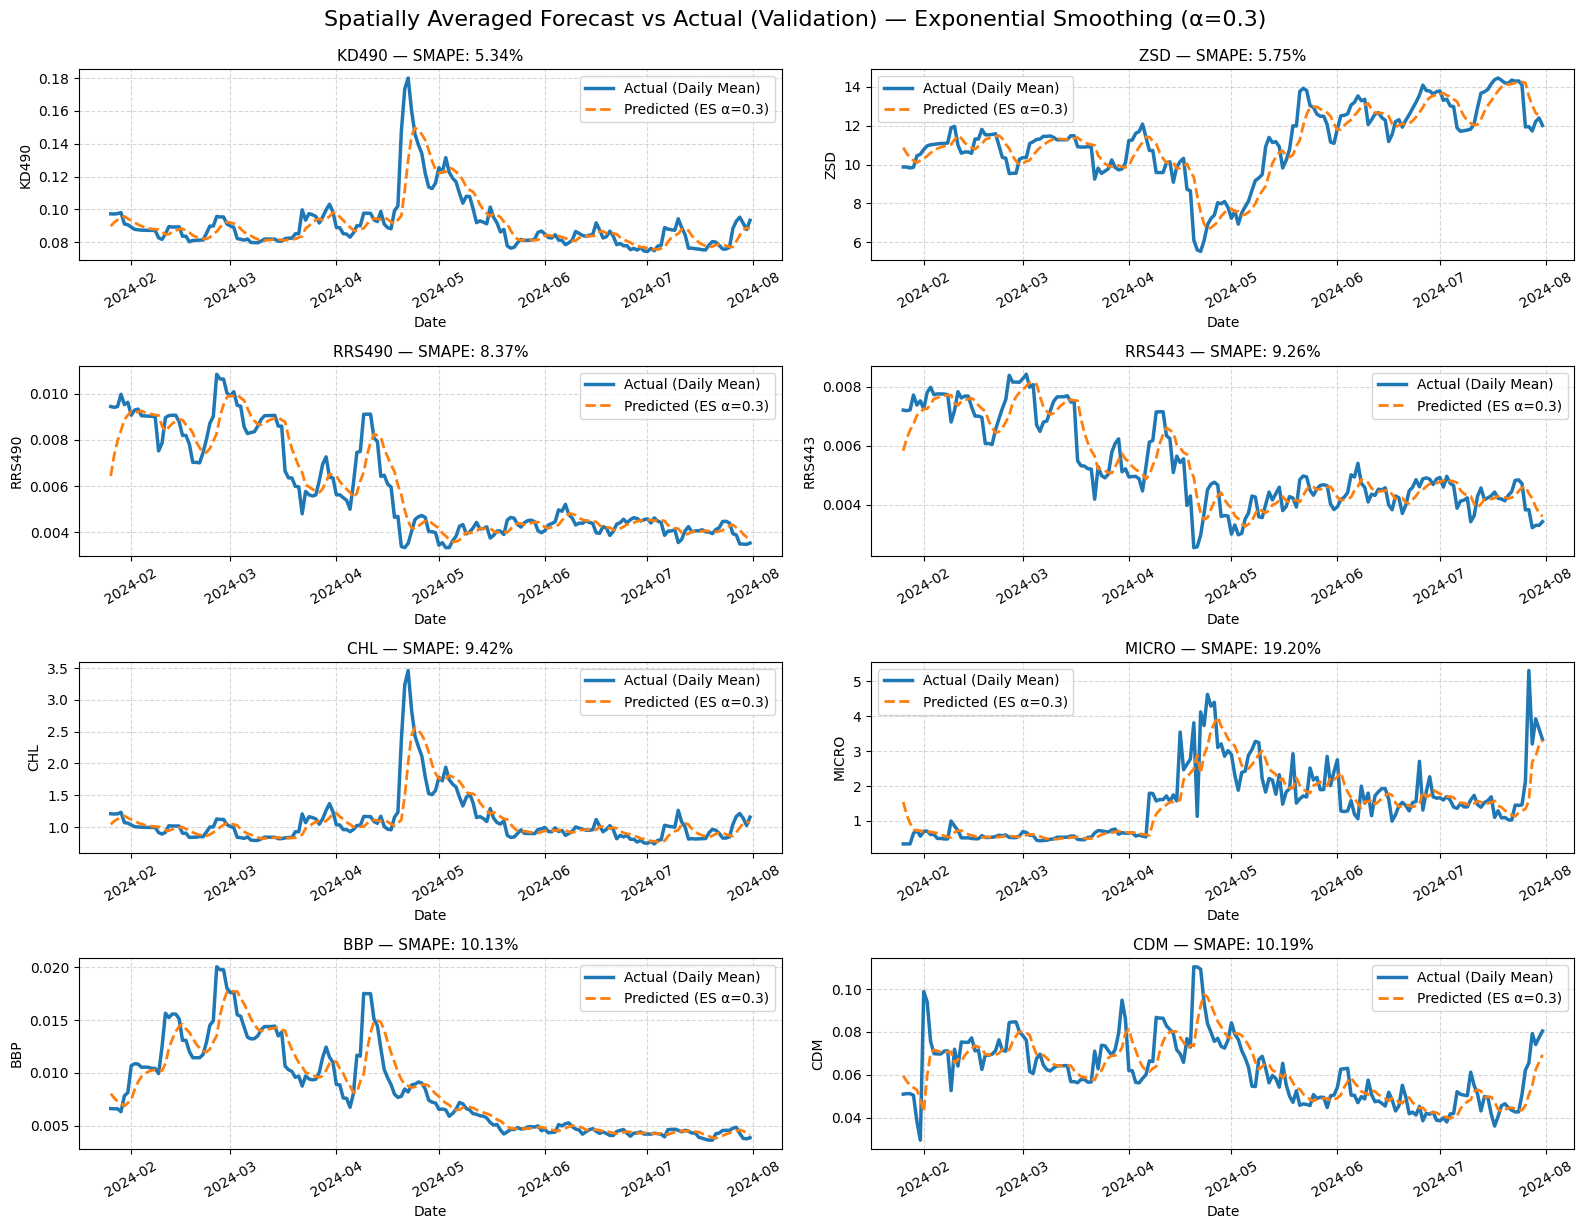

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# --- config ---
ALPHA = 0.3

def symmetric_mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return 100.0 * np.mean(np.where(denom == 0, 0.0, np.abs(y_pred - y_true) / (denom + eps)))

variables = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]
spatial_es_metrics = {}
spatial_predictions = {}  # for plotting per variable

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Build daily spatial mean series for train and val
    df = data[["date", "lat_5km", "lon_5km", var]].dropna().copy()
    df.sort_values(["date"], inplace=True)

    # daily mean across grids
    daily = df.groupby("date")[var].mean()

    train_series = daily[daily.index.isin(train_dates)]
    val_series   = daily[daily.index.isin(val_dates)]

    if len(train_series) < 5 or len(val_series) == 0:
        ax = axes[i]
        ax.set_title(f"{var} — Insufficient train/val data"); ax.axis("off")
        continue

    # Fit SES on train
    model = SimpleExpSmoothing(train_series).fit(smoothing_level=ALPHA, optimized=False)
    last_fitted = model.fittedvalues[-1]

    # Recursive one-step-ahead over validation
    preds = []
    for d in val_series.index:
        hist = daily.loc[:d]
        prev_value = hist.iloc[-2] if len(hist) > 1 else last_fitted
        last_fitted = ALPHA * prev_value + (1.0 - ALPHA) * last_fitted
        preds.append((d, val_series.loc[d], last_fitted))

    pred_df = pd.DataFrame(preds, columns=["date", "actual", "predicted"]).set_index("date").sort_index()
    spatial_predictions[var] = pred_df

    # Metrics
    err = pred_df["predicted"].to_numpy() - pred_df["actual"].to_numpy()
    mae  = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    smape = float(symmetric_mape(pred_df["actual"], pred_df["predicted"]))

    spatial_es_metrics[var] = {"SMAPE (%)": smape, "RMSE": rmse, "MAE": mae}

    # Plot
    ax = axes[i]
    ax.plot(pred_df.index, pred_df["actual"], linewidth=2.5, label="Actual (Daily Mean)")
    ax.plot(pred_df.index, pred_df["predicted"], linestyle="--", linewidth=2.0, label=f"Predicted (ES α={ALPHA})")
    ax.set_title(f"{var} — SMAPE: {smape:.2f}%", fontsize=11)
    ax.set_xlabel("Date"); ax.set_ylabel(var)
    ax.tick_params(axis="x", rotation=30)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.suptitle(f"Spatially Averaged Forecast vs Actual (Validation) — Exponential Smoothing (α={ALPHA})", fontsize=16, y=1.02)
plt.show()

In [21]:
# Summary table for spatial exponential smoothing
print("\nSummary of Evaluation Metrics (Spatial Average + Exponential Smoothing):")
spatial_exp_summary_df = pd.DataFrame(spatial_es_metrics).T.round(4)
print(spatial_exp_summary_df)



Summary of Evaluation Metrics (Spatial Average + Exponential Smoothing):
        SMAPE (%)    RMSE     MAE
KD490      5.3362  0.0091  0.0053
ZSD        5.7477  0.8063  0.6057
RRS490     8.3745  0.0008  0.0005
RRS443     9.2628  0.0006  0.0005
CHL        9.4248  0.2328  0.1187
MICRO     19.1992  0.5432  0.3179
BBP       10.1321  0.0015  0.0010
CDM       10.1874  0.0096  0.0064


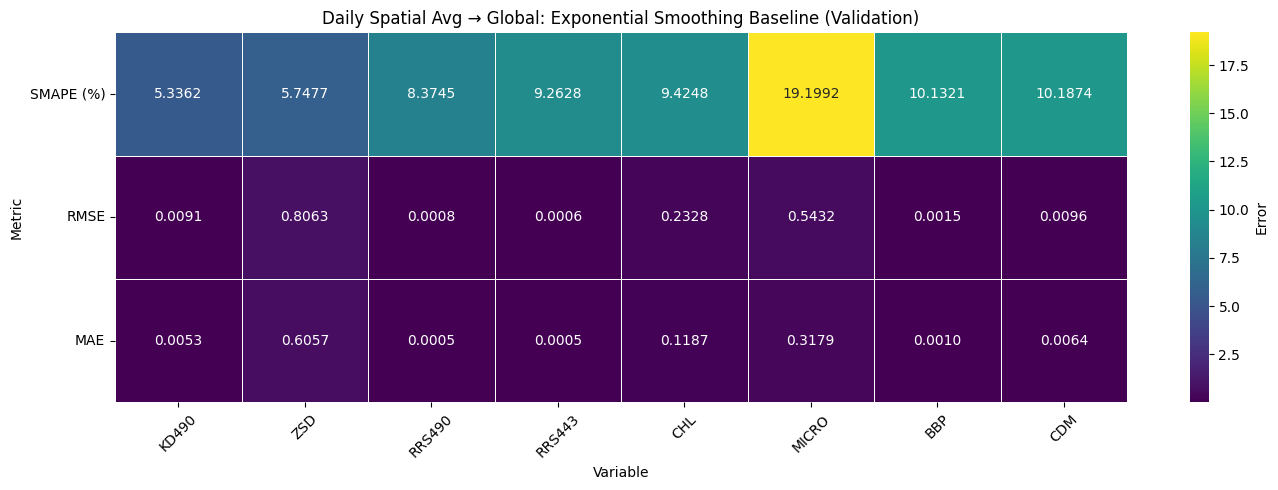

In [22]:
metrics_df_spatial_es = pd.DataFrame(spatial_es_metrics).T
wanted = ["SMAPE (%)", "RMSE", "MAE"]
for col in wanted:
    if col not in metrics_df_spatial_es.columns:
        metrics_df_spatial_es[col] = np.nan

heatmap_data_spatial_es = metrics_df_spatial_es[wanted].T

plt.figure(figsize=(14, 5))
sns.heatmap(
    heatmap_data_spatial_es,
    annot=True, fmt=".4f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Error"}
)
plt.title("Daily Spatial Avg → Global: Exponential Smoothing Baseline (Validation)")
plt.xlabel("Variable"); plt.ylabel("Metric")
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()